# Practical 2 - NLP
> Monish Gosar (J025)

# Part 1

## Use a pretrained word2vec model (example - word2vec-google-news-300 )

In [1]:
import gensim.downloader as api
from gensim.models import Word2Vec

from nltk.tokenize import word_tokenize

wv_pretrained = api.load("word2vec-google-news-300")

## Pick any 5 words of your choice and find the model similar words for each of these 5 words.

In [12]:
words = ["technology", "ocean", "happiness", "guitar", "cooking"]

for word in words:
    similar_words = wv_pretrained.most_similar(word, topn=5)
    print(f"\n Words similar to '{word}':")
    for similar_word, score in similar_words:
        print(f"{similar_word} (similarity: {score:.4f})")
 


 Words similar to 'technology':
technologies (similarity: 0.8332)
innovations (similarity: 0.6231)
technological_innovations (similarity: 0.6102)
technol (similarity: 0.6047)
technological_advancement (similarity: 0.6036)

 Words similar to 'ocean':
sea (similarity: 0.7644)
oceans (similarity: 0.7483)
Pacific_Ocean (similarity: 0.7037)
Atlantic_Ocean (similarity: 0.6659)
oceanic (similarity: 0.6610)

 Words similar to 'happiness':
contentment (similarity: 0.7695)
joy (similarity: 0.6183)
Happiness (similarity: 0.6116)
hapiness (similarity: 0.5749)
contentedness (similarity: 0.5575)

 Words similar to 'guitar':
guitars (similarity: 0.8396)
acoustic_guitar (similarity: 0.8281)
electric_guitar (similarity: 0.8114)
mandolin (similarity: 0.7817)
harmonica (similarity: 0.7718)

 Words similar to 'cooking':
cook (similarity: 0.7585)
Cooking (similarity: 0.7553)
baking (similarity: 0.6752)
cookery (similarity: 0.6723)
humongous_belly (similarity: 0.6696)


## Just like the experiment from the lecture where we checked king - man + woman ~= queen  - come with 2-3 similar examples and test them with the pretrained word2vec model’s vectors.

> **Example 1 : PLANE-FLY+DRIVE=CAR'**

In [26]:
result = wv_pretrained.most_similar(positive=['plane','drive'],negative=['fly'],topn=5)
result

[('drives', 0.4992702603340149),
 ('car', 0.48844391107559204),
 ('SUV', 0.4541016221046448),
 ('vehicle', 0.4517112672328949),
 ('pickup_truck', 0.4309946596622467)]

> **Example 2 : HOT-SUMMER+COLD=WINTER**

In [33]:
result = wv_pretrained.most_similar(positive=['hot','cold'],negative=['summer'],topn=5)
result

[('chilly', 0.4877217411994934),
 ('Hot', 0.47678613662719727),
 ('Cold', 0.4653787910938263),
 ('steaming_hot', 0.46014639735221863),
 ('frigid', 0.4587932229042053)]

# PART 2

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import re

movie = pd.read_csv("IMDB Dataset.csv")
movie.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [41]:
movie.isna().sum()

review       0
sentiment    0
dtype: int64

In [42]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### EDA

<Axes: xlabel='sentiment'>

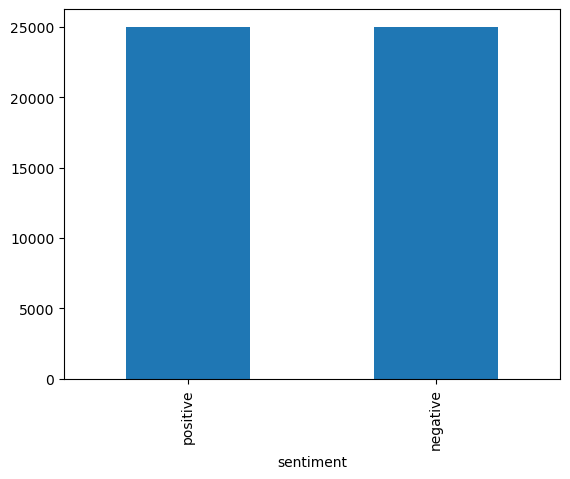

In [43]:
movie['sentiment'].value_counts().plot(kind='bar')

C:\Users\monis\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='review_length', ylabel='Count'>

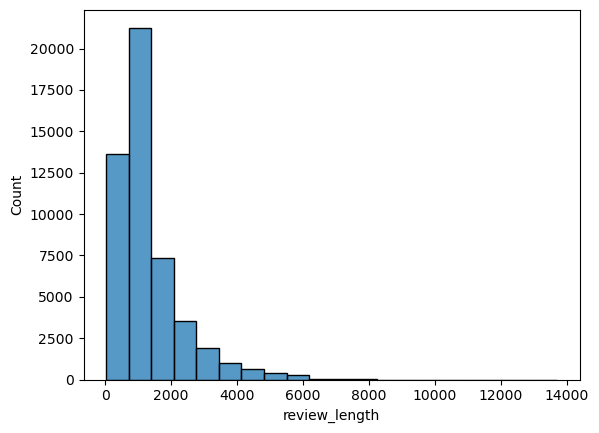

In [47]:
movie['review_length'] = movie['review'].str.len()
sns.histplot(movie, x='review_length', bins=20)

In [49]:
from wordcloud import WordCloud
text = ' '.join(movie['review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

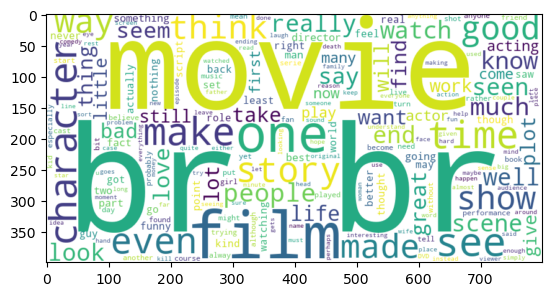

In [52]:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')

In [55]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return ' '.join([word for word in text.split() if word not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [58]:
movie['cleaned_review'] = movie['review'].apply(clean_text)

In [59]:
movie.cleaned_review.head()

0    one reviewers mentioned watching 1 oz episode ...
1    wonderful little production br br filming tech...
2    thought wonderful way spend time hot summer we...
3    basically theres family little boy jake thinks...
4    petter matteis love time money visually stunni...
Name: cleaned_review, dtype: object

In [66]:
from gensim.models import Word2Vec
import multiprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import re

train_sentences, test_sentences, train_labels, test_labels = train_test_split(movie['cleaned_review'], movie.sentiment, test_size=0.2, random_state=42)

# Train Word2Vec models (Skip-gram and CBOW)
sg_model = Word2Vec(sentences=movie.cleaned_review, vector_size=100, window=5, min_count=5, 
                    workers=multiprocessing.cpu_count(), sg=1)
cbow_model = Word2Vec(sentences=movie.cleaned_review, vector_size=100, window=5, min_count=5, 
                      workers=multiprocessing.cpu_count(), sg=0)


In [67]:
# Function to create document vectors
def document_vector(doc, model):
    doc_vec = np.zeros(model.vector_size)
    count = 0
    for word in doc:
        if word in model.wv:
            doc_vec += model.wv[word]
            count += 1
    if count != 0:
        doc_vec /= count
    return doc_vec

# Create document vectors for train and test sets
X_train_sg = np.array([document_vector(doc, sg_model) for doc in train_sentences])
X_test_sg = np.array([document_vector(doc, sg_model) for doc in test_sentences])

X_train_cbow = np.array([document_vector(doc, cbow_model) for doc in train_sentences])
X_test_cbow = np.array([document_vector(doc, cbow_model) for doc in test_sentences])

y_train = np.array(train_labels)
y_test = np.array(test_labels)

# Train and evaluate logistic regression classifiers
def train_evaluate_classifier(X_train, X_test, y_train, y_test, model_name):
    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Model Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

In [68]:
# Evaluate Skip-gram model
train_evaluate_classifier(X_train_sg, X_test_sg, y_train, y_test, "Skip-gram")

# Evaluate CBOW model
train_evaluate_classifier(X_train_cbow, X_test_cbow, y_train, y_test, "CBOW")



Skip-gram Model Results:
Accuracy: 0.5879
Classification Report:
              precision    recall  f1-score   support

    negative       0.59      0.57      0.58      4961
    positive       0.59      0.60      0.60      5039

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.59     10000
weighted avg       0.59      0.59      0.59     10000


CBOW Model Results:
Accuracy: 0.6101
Classification Report:
              precision    recall  f1-score   support

    negative       0.61      0.59      0.60      4961
    positive       0.61      0.63      0.62      5039

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000

